In [64]:
#lets make all necessary imports
import os
import cv2
import numpy as np
from imutils import paths
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

In [11]:
#lets check for number of data in each class for imbalance checking
covid_img = len(os.listdir("dataset/covid/")) # covid patients dataset
normal_img = len(os.listdir("dataset/normal/")) # normal patient dataset
print("No of covid_images: ", covid_img)
print("No of normal_images: ", normal_img)

No of covid_images:  25
No of normal_images:  25


In [20]:
#Both the classes have equal number of images but still the image count is very low
#lets set the path
imagePaths=list(paths.list_images('dataset/'))

In [38]:
img_data = []
label_data = []
for imagePath in imagePaths:
    #this would extract the labels as either "covid" or "normal"
    label = imagePath.split(os.path.sep)[-2].split('/')[-1]
    #reading the image
    img = cv2.imread(imagePath)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img,(224,224))
    
    img_data.append(img)
    label_data.append(label)

In [39]:
#now lets convert these list to numpy arrays
#image normalizing
img_data = np.array(img_data)/255.0
label_data = np.array(label_data)

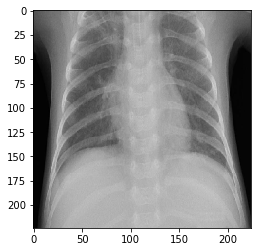

Label: normal


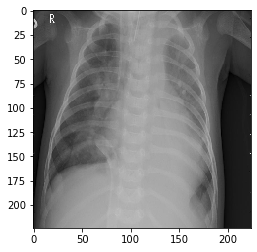

Label: normal


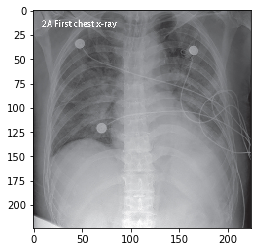

Label: covid


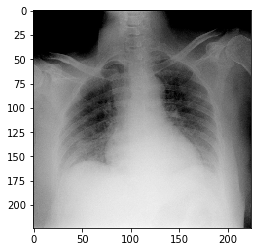

Label: covid


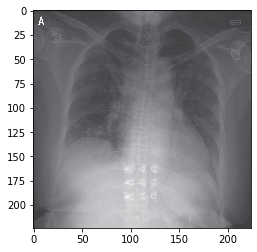

Label: covid


In [51]:
#Now lets plot a random image and its label
for i in range(5):
    idx = np.random.randint(1,50)
    plt.imshow(img_data[idx])
    plt.show()
    print(f"Label: {label_data[idx]}")

In [57]:
#For our loss function we need to perform one-hot encoding on the data
lbl = LabelBinarizer()
label_data = lbl.fit_transform(label_data)
label_data = to_categorical(label_data)
label_data.shape

(50, 2)

In [58]:
#Now let us split the data to train/test
X_train,X_test,y_train,y_test = train_test_split(img_data,
                                                 label_data,
                                                 test_size=0.2,
                                                 stratify=label_data,
                                                 random_state=42)

In [61]:
#data augmentation 
dataAug = ImageDataGenerator(rotation_range=30,zoom_range=0.5,
                            fill_mode='nearest')

In [65]:
#Lets try VGG16 architecture
base_model = VGG16(weights="imagenet",include_top=False,
                  input_tensor=Input(shape=(224,224,3)))

In [74]:
headModel = base_model.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(32, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [75]:
model = Model(inputs=base_model.input,outputs=headModel)

In [77]:
for layer in base_model.layers:
    layer.trainable= False

In [78]:
#few hyperparameters
lr = 1e-3
epochs = 25
batch_size = 8

In [80]:
model.compile(optimizer=Adam(lr=lr,decay = lr/epochs),loss='binary_crossentropy',
             matrics=['accuracy'])

In [81]:
hist = model.fit_generator(
        dataAug.flow(X_train,y_train,batch_size=batch_size),
        steps_per_epoch=len(X_train)//batch_size,
        validation_data=(X_test,y_test),
        validation_steps=(X_test)//batch_size,
        epochs=epochs)

Epoch 1/25
5/5 [==============================] - 7s 1s/step - loss: 0.8386 - val_loss: 0.7155
Epoch 2/25
5/5 [==============================] - 1s 273ms/step - loss: 0.8810 - val_loss: 0.7094
Epoch 3/25
5/5 [==============================] - 1s 274ms/step - loss: 0.7857 - val_loss: 0.7086
Epoch 4/25
5/5 [==============================] - 1s 273ms/step - loss: 0.7641 - val_loss: 0.7071
Epoch 5/25
5/5 [==============================] - 1s 274ms/step - loss: 0.7491 - val_loss: 0.7092
Epoch 6/25
5/5 [==============================] - 1s 274ms/step - loss: 0.6289 - val_loss: 0.7136
Epoch 7/25
5/5 [==============================] - 1s 278ms/step - loss: 0.6735 - val_loss: 0.7096
Epoch 8/25
5/5 [==============================] - 1s 273ms/step - loss: 0.7043 - val_loss: 0.6992
Epoch 9/25
5/5 [==============================] - 1s 274ms/step - loss: 0.6974 - val_loss: 0.6937
Epoch 10/25
5/5 [==============================] - 1s 274ms/step - loss: 0.7460 - val_loss: 0.6873
Epoch 11/25
5/5 [=====

In [83]:
preds = model.predict(X_test,batch_size=batch_size)

In [87]:
preds_idx = np.argmax(preds,axis=1)

In [89]:
#classification report
print(classification_report(y_test.argmax(axis=1),preds_idx,
                     target_names=lbl.classes_))

              precision    recall  f1-score   support

       covid       1.00      0.20      0.33         5
      normal       0.56      1.00      0.71         5

    accuracy                           0.60        10
   macro avg       0.78      0.60      0.52        10
weighted avg       0.78      0.60      0.52        10



In [107]:
test_img = cv2.imread(imagePaths[1])

dataset/covid\1-s2.0-S0929664620300449-gr2_lrg-a.jpg


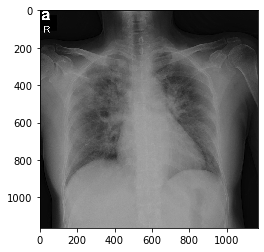

In [108]:
print(imagePaths[1])
plt.imshow(test_img)
plt.show()

In [109]:
test_img = cv2.resize(test_img,(224,224))

In [110]:
test_img= test_img / 255.0

In [111]:
res = model.predict(test_img.reshape(-1,224,224,3))

In [112]:
lbl.classes_[np.argmax(res)]

'covid'